In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
from attributionpriors import eager_ops
from path_explain import PathExplainerTF
import shap

ModuleNotFoundError: No module named 'utils'

In [ ]:
PathExplainerTF

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()

In [4]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

In [5]:
mean = x_train.mean(axis = 0)
std  = x_train.std(axis  = 0)
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

In [6]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu,
                           input_shape=(x_train.shape[1],)),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.SGD(0.0001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x_train, y_train, epochs=500,
                    validation_split=0.2, verbose=0)

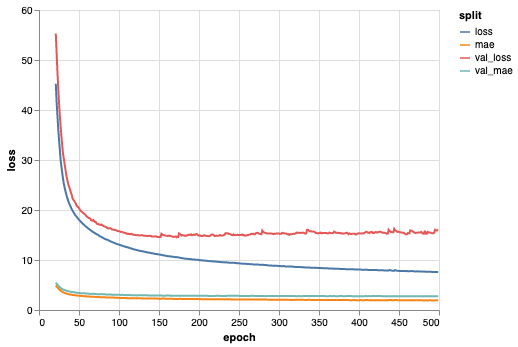

In [8]:
data_df = pd.DataFrame(history.history)
data_df['epoch'] = history.epoch
melt_df = pd.melt(data_df, id_vars=['epoch'], var_name='split', value_name='loss')
alt.Chart(melt_df).mark_line().transform_filter(
    'datum.epoch > 20'
).encode(
    alt.X('epoch:Q'),
    alt.Y('loss:Q'),
    alt.Color('split:N')
)

In [9]:
[loss, mae] = model.evaluate(x_test, y_test, verbose=0)

print("Test set mean absolute error: ${:7.2f}".format(mae * 1000))

Test set mean absolute error: $3338.50


In [63]:
explainer = PathExplainerTF(model)
eg_from_path = explainer.attributions(x_test,
                                      x_train,
                                      batch_size=50,
                                      num_samples=1000,
                                      use_expectation=True,
                                      verbose=True)

100%|██████████| 102/102 [00:08<00:00, 11.93it/s]


In [77]:
grad_explainer = shap.GradientExplainer(model, x_train, batch_size=50)
eg_from_shap = grad_explainer.shap_values(x_test, nsamples=1000)

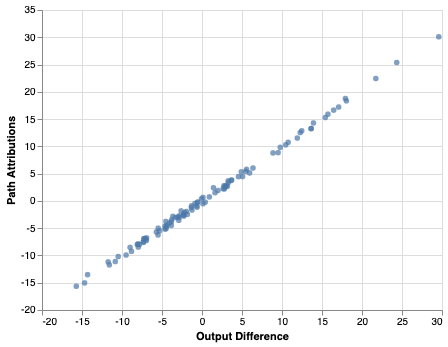

In [69]:
completeness_df = pd.DataFrame({
    'Output Difference': model(x_test).numpy()[:, 0] - np.mean(model(x_train)),
    'Path Attributions': np.sum(eg_from_path, axis=-1)[0]
})
alt.Chart(completeness_df).mark_point(filled=True).encode(
    alt.X('Output Difference:Q'),
    alt.Y('Path Attributions:Q')
)

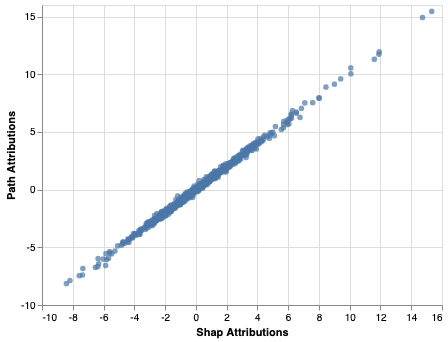

In [80]:
completeness_df = pd.DataFrame({
    'Shap Attributions': eg_from_shap[0].flatten(),
    'Path Attributions': eg_from_path.flatten()
})
alt.Chart(completeness_df).mark_point(filled=True).encode(
    alt.X('Shap Attributions:Q'),
    alt.Y('Path Attributions:Q')
)